### Training all the models for main_project_notebook.


This notebook contains the code for training of the baseline CNN, autoencoder and the CNN with augmented data. These models are safed in a .tf format and loaded into the main_project_notebook.ipynb file. 
First the required libraries are imported.

In [11]:
# Load the functions and classes from main_util.py
from main_util import get_pcam_generators
from main_util import Model_architecture
from main_util import Model_transform

# Modelcheckpoint and tensorboard callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
import os

import matplotlib.pyplot as plt


### Instantiating data generators

The PatchCAMELYON dataset is too big to fit in the working memory of most personal computers. This is why, we need to define some functions that will read the image data batch by batch, so only a single batch of images needs to be stored in memory at one time point. We can use the handy ImageDataGenerator function from the Keras API to do this. Note that the generators are defined within the function `get_pcam_generators` that returns them as output arguments. This function will later be called from the main code body. The function is located in `main_util.py`.

Before executing the code block below, do not forget to change the path where the PatchCAMELYON dataset is located (that is, the location of the folder that contains `train+val` that you previously downloaded and unpacked).

If everything is correct, the following output will be printed on screen after executing the code block:

`Found 144000 images belonging to 2 classes.`

`Found 16000 images belonging to 2 classes.`

In [15]:
path = 'C:/Users/20212150/Documents/Year 3/Q3/Project AI mia'
train_gen, val_gen = get_pcam_generators(path, 
                                         train_batch_size=16, 
                                         val_batch_size=16,
                                         class_mode="binary")

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


### training baseline CNN

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Model: "model_architecture_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 1, 1, 64)          147520    
                         

c:\Users\20212150\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


900/900 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.7803
Epoch 2: val_loss did not improve from 0.40008
900/900 [==============================] - 37s 42ms/step - loss: 0.4756 - accuracy: 0.7803 - val_loss: 0.6800 - val_accuracy: 0.6706
Epoch 3/30
899/900 [============================>.] - ETA: 0s - loss: 0.4619 - accuracy: 0.7836
Epoch 3: val_loss improved from 0.40008 to 0.34387, saving model to trained_models\cnn_baseline_weights.hdf5
900/900 [==============================] - 37s 41ms/step - loss: 0.4618 - accuracy: 0.7836 - val_loss: 0.3439 - val_accuracy: 0.8406
Epoch 4/30
899/900 [============================>.] - ETA: 0s - loss: 0.4517 - accuracy: 0.7926
Epoch 4: val_loss did not improve from 0.34387
900/900 [==============================] - 40s 45ms/step - loss: 0.4516 - accuracy: 0.7926 - val_loss: 0.3792 - val_accuracy: 0.8550
Epoch 5/30
899/900 [============================>.] - ETA: 0s - loss: 0.4394 - accuracy: 0.8023
Epoch 5: val_loss did not

INFO:tensorflow:Assets written to: trained_models/cnn_baseline.tf\assets


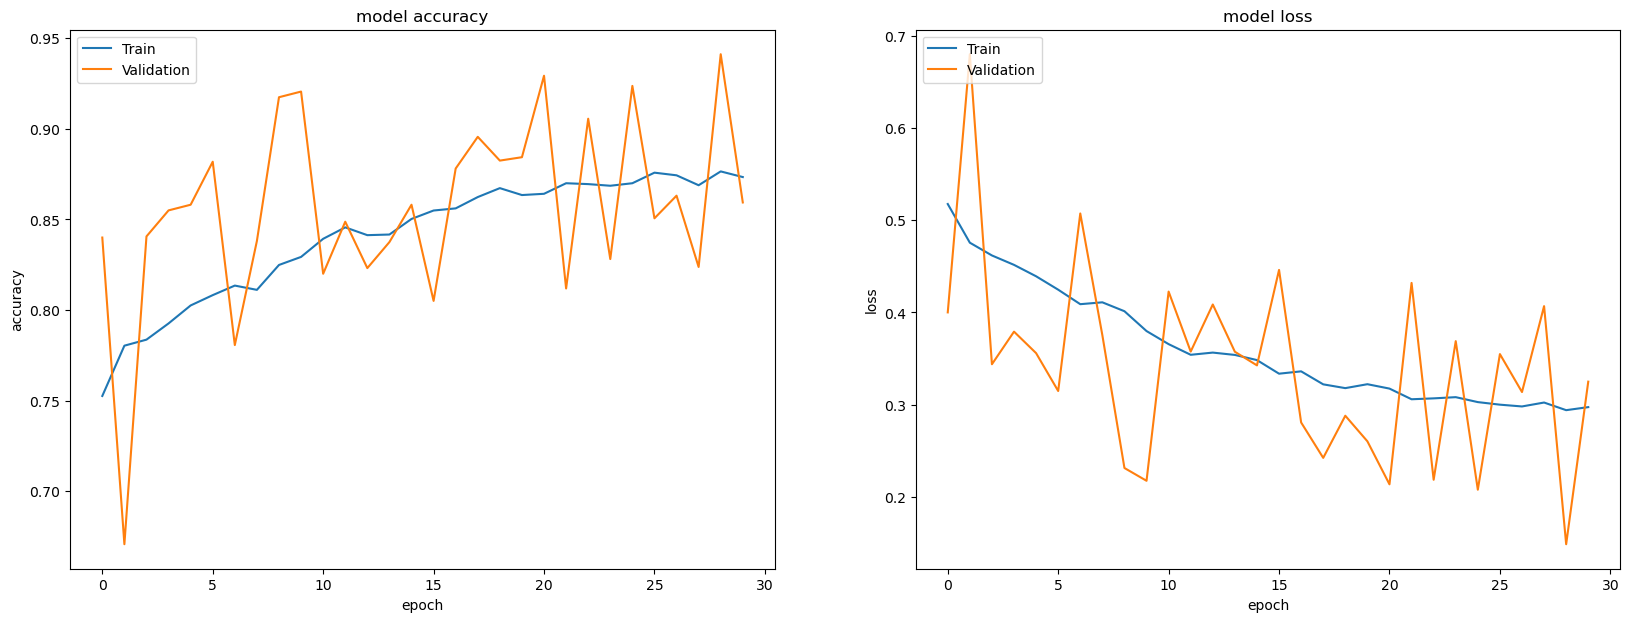

In [13]:
# Defining model name and paths
model_name = "cnn_baseline"
save_filepath = f"trained_models/{model_name}.tf"
model_filepath = f"trained_models/{model_name}.json"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

# Class instance is made
model_cnn = Model_architecture()
model_cnn.create_cnn(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64)
model_cnn.compile_cnn(learning_rate=0.001)

# Prints a summary of the model structure
model_cnn.summary();

# Serialize model to JSON
model_json = model_cnn.to_json()
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 

# Define the Tensorboard callback
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join("logs", model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps = train_gen.n//train_gen.batch_size//10
val_steps = val_gen.n//val_gen.batch_size//10

history = model_cnn.fit(train_gen, steps_per_epoch=train_steps,
                        validation_data=val_gen,
                        validation_steps=val_steps,
                        epochs=30,
                        callbacks=callbacks_list)

model_cnn.save(save_filepath)

fig,ax = plt.subplots(1,2,figsize=(20,7))

# make plot for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')


# make plot for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

### training autoencoder
First, the model name and the filepath for the saved model are defined. Next, we need to construct new data generators. The training process of the autoencoder is unsupervised so the class mode of the data generators should be set to `input`. With these new generators, the autoencoder can be trained effectively. 

In [14]:
# Defining model name and paths
model_name = "autoencoder"
save_filepath = f"trained_models/{model_name}.tf"
model_filepath = f"trained_models/{model_name}.json"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

# Constructing the data generators for unsupervised learning for autoencoder training
train_gen_ae, val_gen_ae = get_pcam_generators(path, 
                                               train_batch_size=16, 
                                               val_batch_size=16, 
                                               class_mode="input") 

model_ae = Model_architecture()
model_ae.create_autoencoder(kernel_size=(3,3), pool_size=(2,2), first_filters=32, second_filters=16)
model_ae.compile_autoencoder(learning_rate=0.001)

model_ae.summary();

# Serialize model to JSON
model_json = model_ae.to_json() 
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 

# Define the Tensorboard callback
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join("logs", model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps = train_gen_ae.n//train_gen_ae.batch_size
val_steps = val_gen_ae.n//val_gen_ae.batch_size

history = model_ae.fit(train_gen_ae, steps_per_epoch=train_steps,
                        validation_data=val_gen_ae,
                        validation_steps=val_steps,
                        epochs=3,
                        callbacks=callbacks_list)

model_ae.save(save_filepath)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Model: "model_architecture_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 48, 48, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 24, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 24, 24, 16)        2320      
                         

c:\Users\20212150\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9000/9000 [==============================] - ETA: 0s - loss: 0.0084
Epoch 2: val_loss improved from 0.00888 to 0.00820, saving model to trained_models\autoencoder_weights.hdf5
9000/9000 [==============================] - 1556s 173ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 3/3
9000/9000 [==============================] - ETA: 0s - loss: 0.0078
Epoch 3: val_loss improved from 0.00820 to 0.00762, saving model to trained_models\autoencoder_weights.hdf5
9000/9000 [==============================] - 1401s 156ms/step - loss: 0.0078 - val_loss: 0.0076
INFO:tensorflow:Assets written to: trained_models/autoencoder.tf\assets


INFO:tensorflow:Assets written to: trained_models/autoencoder.tf\assets


### training CNN with augmented data
The generators for the augmented data are initialized with the autoencoder model as preprocessing function. This is done with the class `Model_transform`. This class is located in `main_util.py` and is responsible for augmenting the input of the data generators. In the code below the variable AUGMENTATION_FACTOR can be changed to adapt the amount of augemented data used for training. For example, 0.75 means 75% augmented data and 25% original data.

In [ ]:
# Constructing the data generators for the augmented dataset  
AUGMENTATION_FACTOR = 0.75

transformation = Model_transform(ae_model=model_ae, augmentation_factor=AUGMENTATION_FACTOR)
train_gen_aug, val_gen_aug = get_pcam_generators(path, 
                                                 train_batch_size=16,
                                                 val_batch_size=16,
                                                 class_mode="binary", 
                                                 prep_function=transformation.model_transform)

# Defining model name and paths
model_name = "cnn_augmented" + str(AUGMENTATION_FACTOR)
save_filepath = f"trained_models/{model_name}.tf"
model_filepath = f"trained_models/{model_name}.json"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

model_cnn_aug = Model_architecture()
model_cnn_aug.create_cnn(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64)
model_cnn_aug.compile_cnn(learning_rate=0.001)

model_cnn_aug.summary()

# Serialize model to JSON
model_json = model_cnn_aug.to_json() 
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 

# Define the Tensorboard callback
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join("logs", model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps = train_gen_aug.n//train_gen_aug.batch_size//10
val_steps = val_gen_aug.n//val_gen_aug.batch_size//10

history = model_cnn_aug.fit(train_gen_aug, steps_per_epoch=train_steps,
                        validation_data=val_gen_aug,
                        validation_steps=val_steps,
                        epochs=30, 
                        callbacks=callbacks_list)

model_cnn_aug.save(save_filepath)

fig,ax = plt.subplots(1,2,figsize=(20,7))

# make plot for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')


# make plot for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

basedir = '.../project_map/main_project/metric_images/'
filename = basedir + model_name + '.png'
plt.savefig(filename)
#plt.show()
                            